In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

importing imfits from D:\L1489_IRS_ssp\imfits


In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
#res_prefix = 'rs_empkep_fixr_rms_SLAM_vcut_lwerN_bnds_high_tbnds_sf_bf' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [4]:
def emp_kep_v(v_rot, v_100, p):        
        r_au = 100.*np.power(v_100/v_rot, 1/p)
        return r_au

def emp_kep_r(r,r_b, v_100, p):
        v_r = v_100*(r/100)**(-p)
        return v_r

In [5]:
def bff_function(a,p,r):

    return 1. - np.exp(- a * np.power(r,p))

def beam_dilution_correction(Tb, r, Tb_err):

    a = 1.1321e-01
    p = 1.8575e+00
    bff_err = 0.09
    bff = bff_function(a,p,r)
    
    Tb_corrected = Tb/bff
    Tb_corr_err = np.sqrt((Tb_err/bff)**2 + bff_err**2)

    return Tb_corrected, Tb_corr_err, bff, bff_err

In [6]:
# constants (in cgs)
from astropy import constants, units

Ggrav  = constants.G.cgs.value        # Gravitational constant
ms     = constants.M_sun.cgs.value    # Solar mass (g)
ls     = constants.L_sun.cgs.value    # Solar luminosity (erg s^-1)
rs     = constants.R_sun.cgs.value    # Solar radius (cm)
au     = units.au.to('cm')            # 1 au (cm)
pc     = units.pc.to('cm')            # 1 pc (cm)
clight = constants.c.cgs.value        # light speed (cm s^-1)
kb     = constants.k_B.cgs.value      # Boltzman coefficient
hp     = constants.h.cgs.value        # Planck constant
sigsb  = constants.sigma_sb.cgs.value # Stefan-Boltzmann constant (erg s^-1 cm^-2 K^-4)
mp     = constants.m_p.cgs.value      # Proton mass (g) 


def IvTOTex(Iv, nu0, bmaj, bmin, sigI=None):
    '''
    Convert Iv to Tb WITHOUT Rayleigh-Jeans approximation.

    Parameters
    ----------
        nu0 (float): Rest frequency [Hz]
        bmaj (float): Major beam size [deg]
        bmin (float): Minor beam size [deg]
        Iv (array or float): Intensity [Jy/beam]
        sigI (array or float): Sigma of intensity [Jy/beam]

    Others
    ------
        C1: coefficient to convert Iv to Tex
        C2: coefficient to convert beam to str
    '''

    bmaj = bmaj*np.pi/180. # deg --> radian
    bmin = bmin*np.pi/180. # deg --> radian

    C1=2.*hp*(nu0*nu0*nu0)/(clight*clight) # in cgs

    # Jy/beam -> Jy/str
    # Omg_beam (str) = (pi/4ln(2))*beam (rad^2)
    # I [Jy/beam] / Omg_beam = I [Jy/str]
    C2 = np.pi/(4.*np.log(2.))  # beam(rad) -> beam (sr)
    bTOstr = bmaj*bmin*C2  # beam --> str
    Istr = Iv/bTOstr # Jy/beam --> Jy/str
    Istr = Istr*1.0e-26 # Jy --> MKS (Jy = 10^-26 Wm-2Hz-1)
    Istr = Istr*1.e7*1.e-4 # MKS --> cgs

    Tex = (hp*nu0/kb)/(np.log(C1/Istr + 1.)) # no approximation [K]

    if sigI is not None:
        # Error propagation
        dT_dI = (hp*nu0/kb) * C1 * (Istr**(-2.)) * (C1/Istr + 1.)**(-1.) \
        * (np.log(C1/Istr + 1.))**(-2) # derivative
        sigI_str = sigI / bTOstr * 1.0e-26 * 1.e7 * 1.e-4
        sigTex = np.sqrt(dT_dI*dT_dI*sigI_str*sigI_str)

        return Tex, sigTex
    else:
        return Tex
    
def IvTOJT(Iv, nu0, bmaj, bmin):
    '''
    Calculate the equivalent brightness temperature from intensity in a unit of Jy/beam.

    Input
     nu0: rest frequency [Hz]
     bmaj: major beam size [deg]
     bmin: minor beam size [deg]
     Iv: intensity [Jy/beam]

    Others
     C2: coefficient to convert beam to str
     JT: equivalent brightness temperature [K]
    '''
    bmaj = bmaj*np.pi/180. # deg --> radian
    bmin = bmin*np.pi/180. # deg --> radian

    # Jy/beam -> Jy/sr
    # Omg_beam (sr) = (pi/4ln(2))*beam (rad^2)
    # I [Jy/beam] / Omg_beam = I [Jy/sr]
    C2 = np.pi/(4.*np.log(2.))  # beam(rad) -> beam (sr)
    bTOstr = bmaj*bmin*C2  # beam --> str
    Istr = Iv/bTOstr # Jy/beam --> Jy/str
    Istr = Istr*1.0e-26 # Jy --> MKS (Jy = 10^-26 Wm-2Hz-1)
    Istr = Istr*1.e7*1.e-4 # MKS --> cgs

    JT = (clight*clight/(2.*nu0*nu0*kb))*Istr # equivalent brightness temperature
    return JT


#### Read the Data

In [7]:
v_sys_b6=7.386 #kmps
v_100_b6 = 2.797
p_index_b6 = 0.511

v_sys_b7=7.289
v_100_b7 =2.811
p_index_b7 = 0.464

v_sys_avg = (v_sys_b6+v_sys_b7)/2
print(v_sys_avg)
v_100_avg = (v_100_b7 + v_100_b6)/2
print(v_100_avg)
p_index_avg = (p_index_b7 + p_index_b6)/2
print(p_index_avg)


# Read b7 data
pv_b7_in_BT = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=v_sys_avg) # V_sys - 7.22, 7.27 7.384
pv_b7_in_BT.read_pv(print_details = True)

# Read b7 data
pv_b7_in_Iv = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=False, v_sys=v_sys_avg) # V_sys - 7.22, 7.27 7.384
pv_b7_in_Iv.read_pv(print_details = True)



7.3375
2.8040000000000003
0.48750000000000004
Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$


### Prepare points

In [8]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = v_100_avg #kmps # idpft-2.674 # JS- 3.2 # newft 2.842

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100_avg, p=p_index_avg)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [9]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100, p=p_index_avg)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [10]:
Tb_b7_before_bff_correction = pv_b7_in_BT.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Iv_b7_before_bff_correction = pv_b7_in_Iv.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

### Calculation

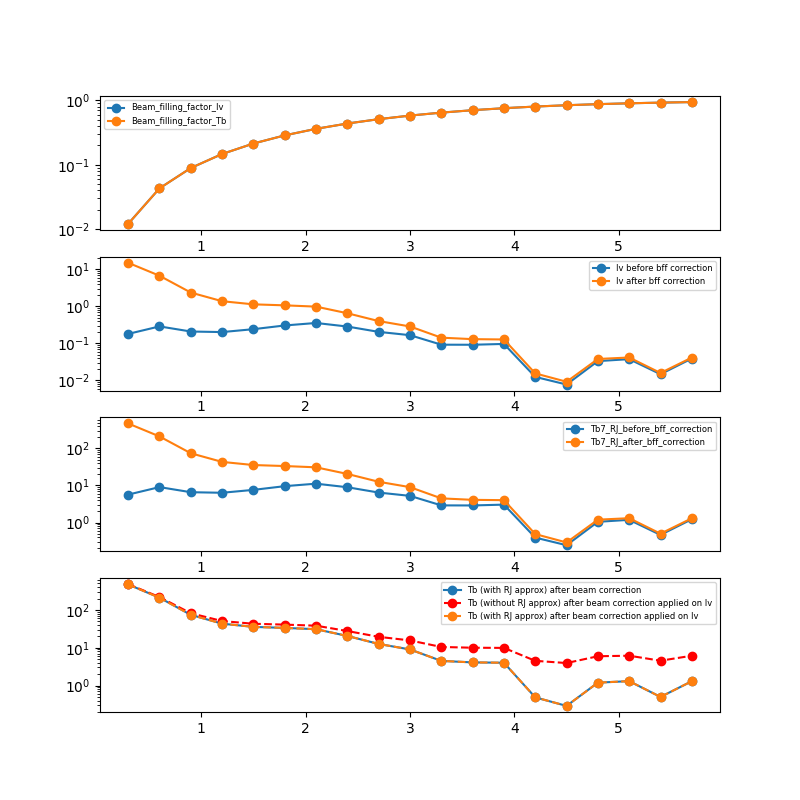

In [12]:

Tb7_read_in_BT_woc  = Tb_b7_before_bff_correction["Tb_on_point_rs"]
r_Tb7_read_in_BT = Tb_b7_before_bff_correction["r_rs"]

Iv_read_in_Jy_woc = Iv_b7_before_bff_correction["Tb_on_point_rs"]
r_Iv_read_in_Jy = Iv_b7_before_bff_correction["r_rs"]



# Beam filling factor correction
Iv_aftr_bff_cor, iv_er,iv_bff, iv_bff_err = beam_dilution_correction(Tb=Iv_read_in_Jy_woc, r = r_Iv_read_in_Jy, 
                                           Tb_err = 3.45e-2*np.ones_like(np.array(r_Iv_read_in_Jy)))

Tb_aftr_bff_cor, tb_er, tb_bff, tb_bff_err = beam_dilution_correction(Tb=Tb7_read_in_BT_woc, r = r_Tb7_read_in_BT, 
                                           Tb_err = 1.01*np.ones_like(np.array(r_Iv_read_in_Jy)))

# Convert Iv to brightness temperature
Iv_nu = (1 - ((pv_b7_in_Iv.v_rot_redshifted+v_sys_avg)/3e8))*329.3305525e9



Tb_Iv_nu = []
for inu, nu in zip(Iv_aftr_bff_cor,  Iv_nu): 
    Tb_Iv_nu.append(IvTOTex(Iv=inu, nu0=nu, bmaj = 0.6/3600, bmin = 0.6/3600))

    

Tb_Iv_nu_RJ = []
for inu, nu in zip(Iv_aftr_bff_cor,  Iv_nu): 
    Tb_Iv_nu_RJ.append(IvTOJT(Iv=inu, nu0 =nu, bmaj = 0.6/3600, bmin = 0.6/3600))


fig, axs = plt.subplots(4, figsize=(8,8))
axs[0].plot(r_Tb7_read_in_BT, iv_bff, label='Beam_filling_factor_Iv', marker='o')
axs[0].plot(r_Iv_read_in_Jy, tb_bff, label='Beam_filling_factor_Tb', marker='o')
axs[0].legend(prop={'size': 6})
axs[0].set_yscale('log')

axs[1].plot(r_Tb7_read_in_BT, Iv_read_in_Jy_woc, label='Iv before bff correction', marker='o')
axs[1].plot(r_Iv_read_in_Jy, Iv_aftr_bff_cor, label='Iv after bff correction', marker='o')
axs[1].legend(prop={'size': 6})
axs[1].set_yscale('log')

axs[2].plot(r_Tb7_read_in_BT, Tb7_read_in_BT_woc, label='Tb7_RJ_before_bff_correction', marker='o')
axs[2].plot(r_Tb7_read_in_BT, Tb_aftr_bff_cor, label='Tb7_RJ_after_bff_correction', marker='o')
axs[2].legend(prop={'size': 6})
axs[2].set_yscale('log')

axs[3].plot(r_Tb7_read_in_BT, Tb_aftr_bff_cor, label='Tb (with RJ approx) after beam correction', marker='o')
axs[3].plot(r_Iv_read_in_Jy, Tb_Iv_nu, c='r', label='Tb (without RJ approx) after beam correction applied on Iv', marker='o', ls = '--')
axs[3].plot(r_Iv_read_in_Jy, Tb_Iv_nu_RJ, label='Tb (with RJ approx) after beam correction applied on Iv', marker='o', ls = '--')
axs[3].legend(prop={'size': 6})
axs[3].set_yscale('log')



#### Data Visualization

In [ ]:

pv_b7_in_BT_dia = pv_b7_in_BT.plot_pv(plot_curve=True)
pv_b7_in_BT_dia[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_b7_in_BT_dia[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_b7_in_Iv_dia = pv_b7_in_Iv.plot_pv(plot_curve=True, cbarlim=[0,1])
pv_b7_in_Iv_dia[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_b7_in_Iv_dia[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)